In [1]:
import numpy as np
import random as rd

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

In [2]:
Nb_model = 10

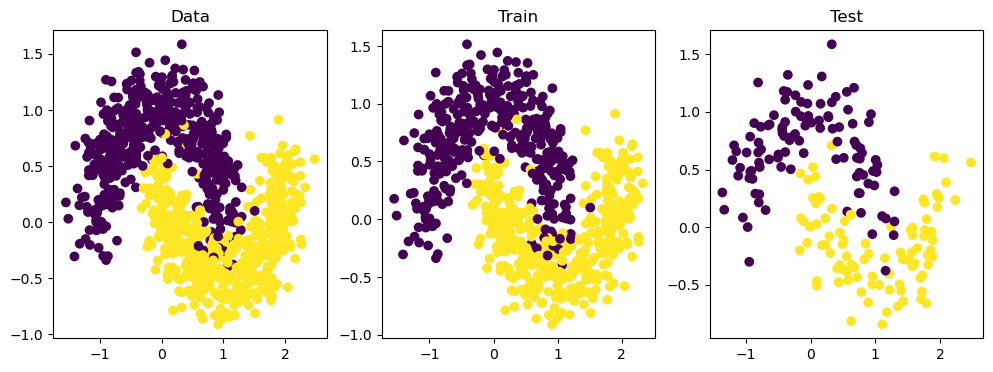

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

[  5 135 151 175 427 457 515 721 745]


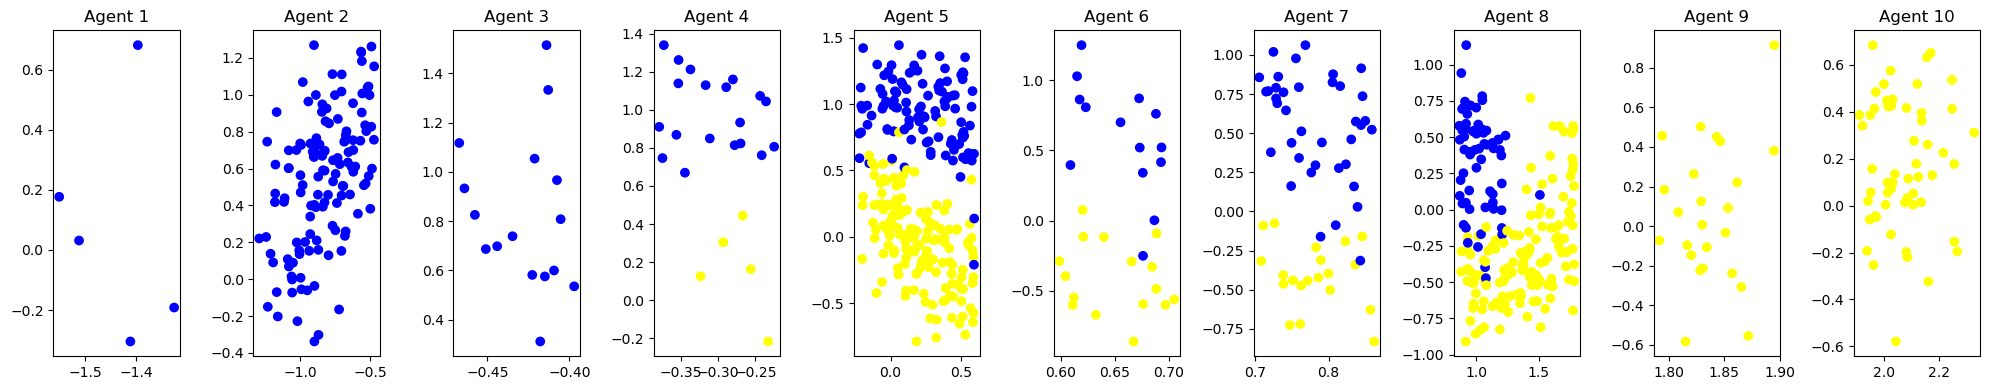

In [4]:

#X_agent, Y_agent = split_into_random_subsets(X_train, Y_train)
X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=1, ncols=Nb_model, figsize=(20, 4))

for i in range(Nb_model):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(Nb_model):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [6]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4], axis=1)

In [7]:
G = np.zeros((Nb_model, Nb_model))
for i in range(Nb_model):
    for j in range(Nb_model):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(Nb_model)
c = np.zeros(Nb_model)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(Nb_model):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize



Max: 252
Min: 5
Mean: 80.0


supposons que l'on réveille d'abord les agents chacun leur tour.

In [8]:
T = 10000
mu = 0.05

## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Monolithic

In [9]:
thetas_mono = np.zeros(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)
    if i % 1000 == 0:
                print(f'Iteration {i+1} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

Iteration 1 : Train: 0.5991 | Test: 0.6097
Iteration 1001 : Train: 0.2555 | Test: 0.2404
Iteration 2001 : Train: 0.2440 | Test: 0.2275
Iteration 3001 : Train: 0.2378 | Test: 0.2206
Iteration 4001 : Train: 0.2334 | Test: 0.2157
Iteration 5001 : Train: 0.2300 | Test: 0.2119
Iteration 6001 : Train: 0.2272 | Test: 0.2087
Iteration 7001 : Train: 0.2249 | Test: 0.2060
Iteration 8001 : Train: 0.2229 | Test: 0.2037
Iteration 9001 : Train: 0.2211 | Test: 0.2015


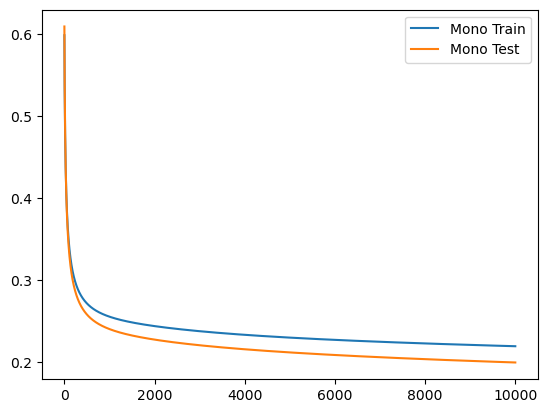

In [10]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

### With multiple agents

In [11]:
thetas_agents = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costs_train_agents = np.zeros((T, Nb_model))
costs_test_agents = np.zeros((T, Nb_model))

print(T)
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, Nb_model, mu, c, G, D)
    for j in range(Nb_model):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents[i]):.4f} and {np.std(costs_train_agents[i]):.4f} | Test: {np.mean(costs_test_agents[i]):.4f} and {np.std(costs_test_agents[i]):.4f}')

10000
Iteration 1 : Train: 0.4617 and 0.1822 | Test: 0.6497 and 0.0566
Iteration 1001 : Train: 0.1483 and 0.1436 | Test: 0.2760 and 0.0191
Iteration 2001 : Train: 0.1433 and 0.1417 | Test: 0.2547 and 0.0222
Iteration 3001 : Train: 0.1417 and 0.1413 | Test: 0.2410 and 0.0216
Iteration 4001 : Train: 0.1411 and 0.1410 | Test: 0.2308 and 0.0202
Iteration 5001 : Train: 0.1411 and 0.1407 | Test: 0.2227 and 0.0186
Iteration 6001 : Train: 0.1418 and 0.1401 | Test: 0.2161 and 0.0170
Iteration 7001 : Train: 0.1431 and 0.1393 | Test: 0.2105 and 0.0156
Iteration 8001 : Train: 0.1453 and 0.1383 | Test: 0.2057 and 0.0143
Iteration 9001 : Train: 0.1485 and 0.1374 | Test: 0.2015 and 0.0131


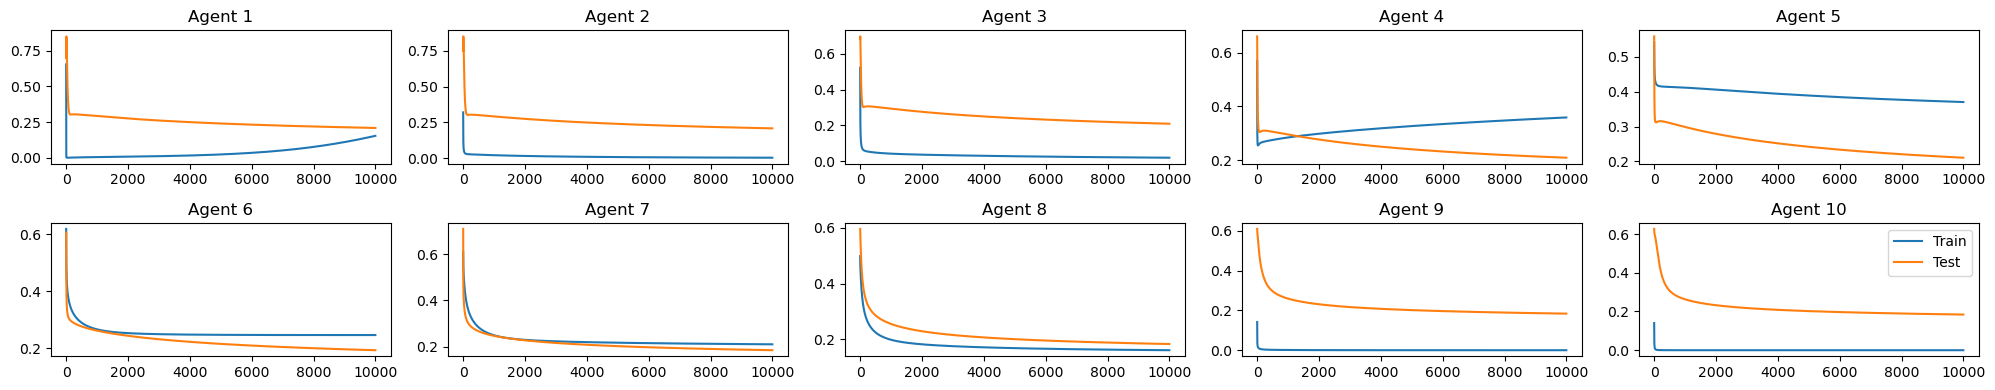

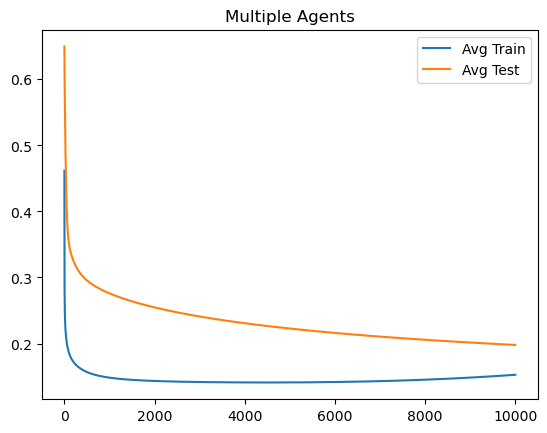

In [12]:
util.plot_curves(Nb_model, costs_train_agents, costs_test_agents, "Multiple Agents")

### Random drawing of Agents

In [13]:
# option 1 : randint avec quota global
tracking  = np.zeros(Nb_model) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*Nb_model

thetas_agents_rand = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_test_agents_rand = np.zeros((total_T, Nb_model))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, Nb_model))


for i in range (total_T) :
    j = rd.randint(0, Nb_model-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, Nb_model, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)
        
    if i % (1000*Nb_model) == 0 :
        print(f'Iteration moyenne {1+i/Nb_model} : Train: {np.mean(costs_train_agents_rand):.4f} and {np.std(costs_train_agents_rand):.4f} | Test: {np.mean(costs_test_agents_rand):.4f} and {np.std(costs_test_agents_rand):.4f}')
       
costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)

Iteration moyenne 1.0 : Train: 0.0000 and 0.0007 | Test: 0.0000 and 0.0007
Iteration moyenne 1001.0 : Train: 0.0017 and 0.0228 | Test: 0.0031 and 0.0319
Iteration moyenne 2001.0 : Train: 0.0031 and 0.0304 | Test: 0.0058 and 0.0412
Iteration moyenne 3001.0 : Train: 0.0045 and 0.0363 | Test: 0.0083 and 0.0478
Iteration moyenne 4001.0 : Train: 0.0060 and 0.0413 | Test: 0.0106 and 0.0530
Iteration moyenne 5001.0 : Train: 0.0074 and 0.0456 | Test: 0.0129 and 0.0572
Iteration moyenne 6001.0 : Train: 0.0088 and 0.0495 | Test: 0.0151 and 0.0608
Iteration moyenne 7001.0 : Train: 0.0102 and 0.0531 | Test: 0.0173 and 0.0640
Iteration moyenne 8001.0 : Train: 0.0116 and 0.0565 | Test: 0.0193 and 0.0668
Iteration moyenne 9001.0 : Train: 0.0131 and 0.0597 | Test: 0.0214 and 0.0692


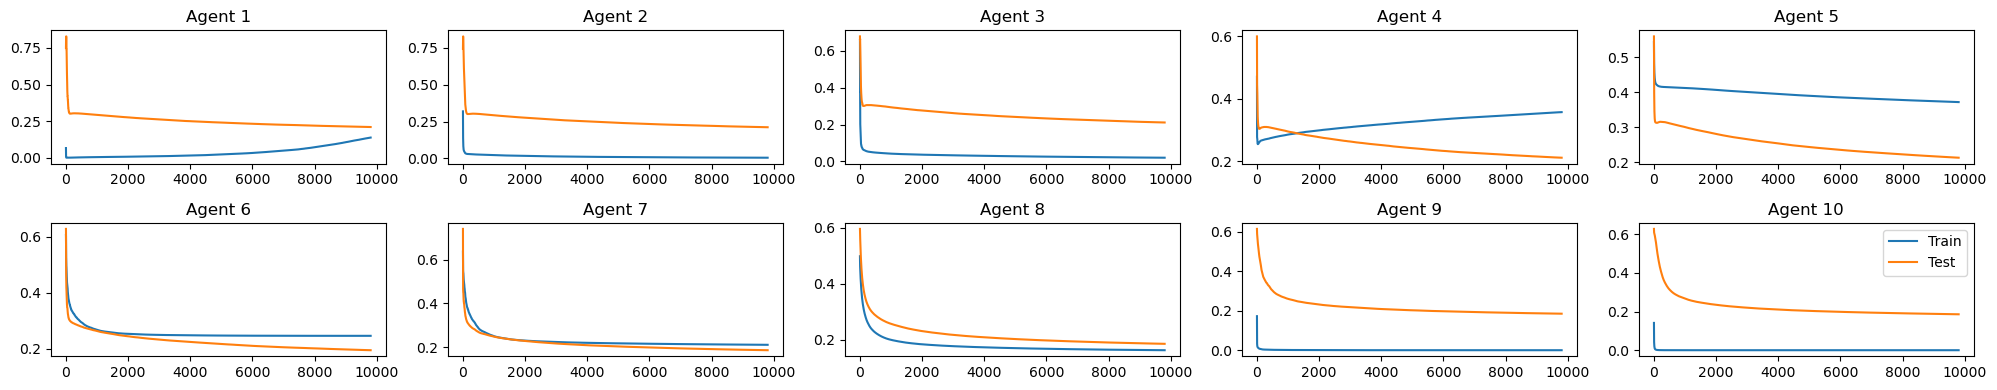

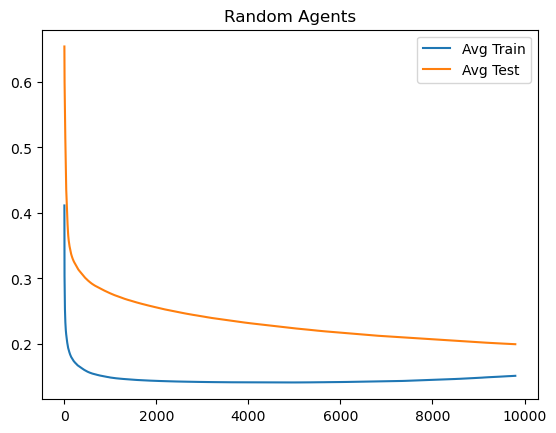

In [14]:
util.plot_curves(Nb_model, costs_train_agents_rand, costs_test_agents_rand, "Random Agents")

### Weighting of Agents

In [15]:
# option 2 : pondérer les agents
tracking  = np.zeros(Nb_model)
total_T = T*Nb_model

thetas_agents_weigh = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_test_agents_weigh = np.zeros((total_T, Nb_model))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, Nb_model))



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(Nb_model)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print(total_T)

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, Nb_model, mu, c, G, D) # y'a probleme

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))
        
    if i % (1000*Nb_model) == 0 :
        print(f'Iteration moyenne {1+i/Nb_model} : Train: {np.mean(costs_train_agents_weigh):.4f} and {np.std(costs_train_agents_weigh):.4f} | Test: {np.mean(costs_test_agents_weigh):.4f} and {np.std(costs_test_agents_weigh):.4f}')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

[0.00625 0.1625  0.02    0.03    0.315   0.0375  0.0725  0.2575  0.03
 0.06875]
100000
Iteration moyenne 1.0 : Train: 0.0000 and 0.0001 | Test: 0.0000 and 0.0006
Iteration moyenne 1001.0 : Train: 0.0024 and 0.0285 | Test: 0.0031 and 0.0313
Iteration moyenne 2001.0 : Train: 0.0045 and 0.0386 | Test: 0.0057 and 0.0408
Iteration moyenne 3001.0 : Train: 0.0066 and 0.0463 | Test: 0.0082 and 0.0474
Iteration moyenne 4001.0 : Train: 0.0087 and 0.0528 | Test: 0.0106 and 0.0526
Iteration moyenne 5001.0 : Train: 0.0108 and 0.0583 | Test: 0.0128 and 0.0569
Iteration moyenne 6001.0 : Train: 0.0127 and 0.0630 | Test: 0.0150 and 0.0605
Iteration moyenne 7001.0 : Train: 0.0147 and 0.0673 | Test: 0.0172 and 0.0637
Iteration moyenne 8001.0 : Train: 0.0167 and 0.0713 | Test: 0.0193 and 0.0665
Iteration moyenne 9001.0 : Train: 0.0187 and 0.0750 | Test: 0.0213 and 0.0690


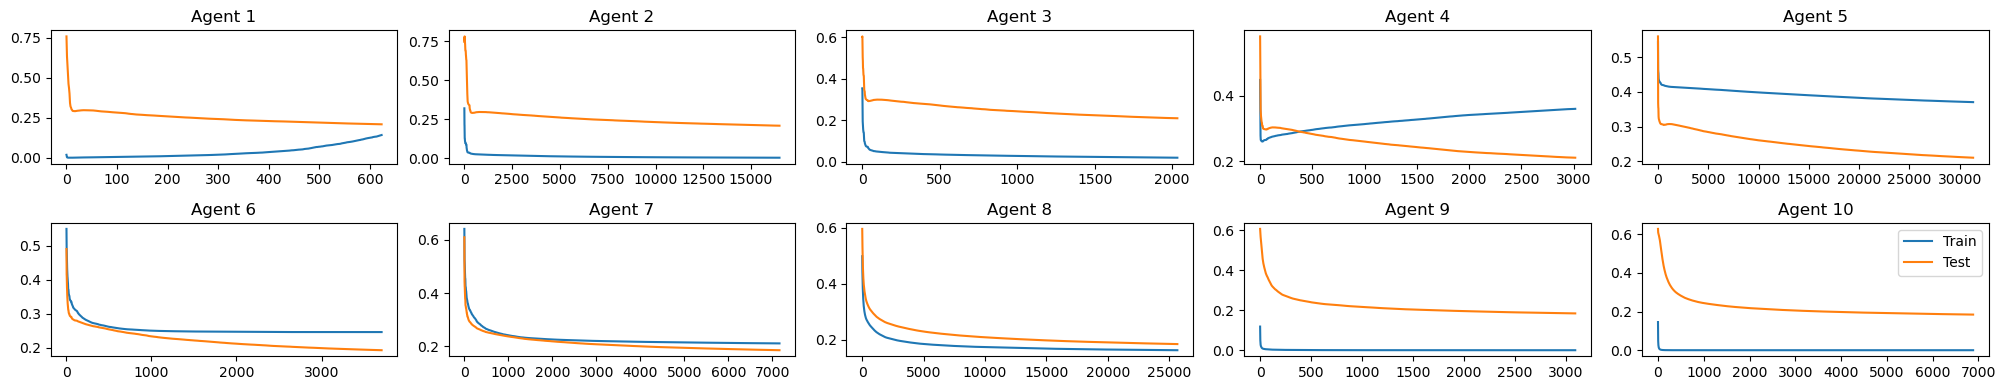

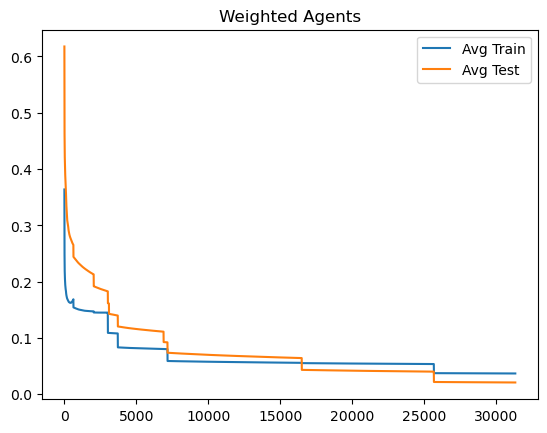

In [16]:
util.plot_curves_non_zero(Nb_model, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, "Weighted Agents")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.


In [17]:
epsilon = 1
L_0 = 0.25

# définit epsilon_barre
epsilon_barre = 3

# technique naïve pour retrouver epsilon : le même à chaque étape

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

thetas_private = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costs_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, Nb_model, mu, c, G, D, L_0, epsilon)
    costs_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, G, D, c, mu)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : {costs_private[i]}')

Iteration 1 : 0.7543041497176345
Iteration 1001 : 0.7428991754101677
Iteration 2001 : 0.7803628161739545
Iteration 3001 : 0.6419186349062549
Iteration 4001 : 0.5907267545539002
Iteration 5001 : 0.48719329441581
Iteration 6001 : 0.5779289308271642
Iteration 7001 : 0.4198009417251327
Iteration 8001 : 0.3976769022553324
Iteration 9001 : 0.3992268764099029


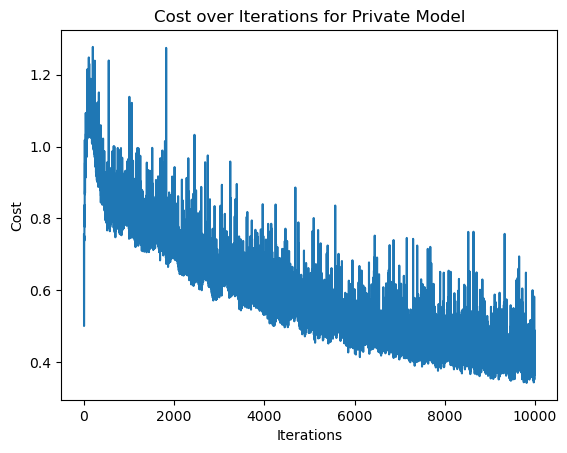

In [18]:
#plt.plot(range(T), costsPrivate, linestyle='-', marker='o')
plt.plot(costs_private)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost over Iterations for Private Model')
plt.show()